In [ ]:
#Run just once if deps are missing
!pip install matplotlib PIL tqdm torch torchvision

In [1]:
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.functional
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

print("All imported Successfully")



All imported Successfully


In [9]:
def display_images(directory: str):
    """Display images from the train dataset"""
    # Get the list of image files in the directory
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    # Randomly select 'num_images' images
    selected_images = random.sample(image_files, min(6, len(image_files)))

    # Display each selected image
    for image_file in selected_images:
        image_path = os.path.join(directory, image_file)
        img = Image.open(image_path)
    # Display image using Matplotlib
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')  # Turn off axis labels
        plt.show()

def create_folder_and_move_files(file_list_path:str, folder_path:str):
    """
    Used to organize data with a given file list and folder name.
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")

    # Read the list of file names from the text file
    with open(file_list_path, 'r') as file:
        file_names = file.read().splitlines()

    # Move the files to the new folder
    for file_name in file_names:
        source_path = os.path.abspath(file_name)
        destination_path = os.path.join(folder_path, os.path.basename(file_name))

        try:
            shutil.move(source_path, destination_path)
            print(f"File '{file_name}' moved to '{folder_path}'.")
        except FileNotFoundError:
            print(f"File '{file_name}' not found in the current directory.")
        except (PermissionError, shutil.Error) as e:
            print(f"Error moving '{file_name}': {e}")

    print("All files moved successfully.")

def save_model(epochs, model, optimizer, criterion):
    """Saves the model to disk"""
    torch.save({
        'epoch': epochs,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss':criterion
    }, 'model.pth')

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#dataset work
train_dir = '/content/drive/MyDrive/train'
valid_dir = '/content/drive/MyDrive/valid'
BATCH_SIZE = 32
data_transform = transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder(root=train_dir,
                                           transform=data_transform)
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)

valid_dataset = datasets.ImageFolder(root=valid_dir,
                                           transform=data_transform)
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE, shuffle=False,
                                             num_workers=4)

In [5]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32,64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)

        self.fc1 = nn.Linear(256, 4)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))

            bs , _ , _, _ = x.shape
            x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
            x = self.fc1(x)
            return x

In [6]:
model = SimpleClassifier()
#from utils import save_model, save_plots
#TODO: use argparser to make it a command line thing
lr = 1e-4
EPOCHS = 30
device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleClassifier().to(device)
print(model)
print(f'Computation on: {device}')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def train(model, datasetloader, optimizer, criterion):
    model.train()
    print('Training...')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(datasetloader), total=len(datasetloader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, pred = torch.max(outputs.data, 1)
        train_running_correct += (pred==labels).sum().item()
        loss.backward() #Backprop
        optimizer.step()
        counter +=1
    epoch_loss = train_running_loss/counter
    epoch_acc = 100. *(train_running_correct / len(datasetloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, datasetloader, criterion):
    model.eval()
    print('Validating...')
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(datasetloader), total=len(datasetloader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            val_running_correct += (pred == labels).sum().item()
            counter += 1  # Increment counter
    epoch_loss = val_running_loss / counter
    epoch_acc = 100. * (val_running_correct / len(datasetloader.dataset))
    return epoch_loss, epoch_acc




SimpleClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=4, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Computation on: cuda


In [7]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1} of {EPOCHS}')
    train_epoch_loss, train_epoch_acc = train(model, train_dataset_loader,
                                               optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_dataset_loader, criterion)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)
    print(f'Train Loss: {train_epoch_loss:.3f}, Train Accuracy: {train_epoch_acc:.3f}')
    print(f'Validation Loss: {valid_epoch_loss:.3f}, Validation Accuracy: {valid_epoch_acc:.3f}')
    print("."*50)

Epoch 1 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.977, Train Accuracy: 58.984
Validation Loss: 0.835, Validation Accuracy: 64.631
..................................................
Epoch 2 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.638, Train Accuracy: 75.525
Validation Loss: 0.714, Validation Accuracy: 72.137
..................................................
Epoch 3 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.532, Train Accuracy: 79.975
Validation Loss: 0.663, Validation Accuracy: 72.519
..................................................
Epoch 4 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.505, Train Accuracy: 80.479
Validation Loss: 0.667, Validation Accuracy: 73.664
..................................................
Epoch 5 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.457, Train Accuracy: 83.123
Validation Loss: 0.606, Validation Accuracy: 74.682
..................................................
Epoch 6 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.452, Train Accuracy: 82.284
Validation Loss: 0.590, Validation Accuracy: 75.445
..................................................
Epoch 7 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.433, Train Accuracy: 83.837
Validation Loss: 0.618, Validation Accuracy: 73.537
..................................................
Epoch 8 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.408, Train Accuracy: 85.390
Validation Loss: 0.648, Validation Accuracy: 74.300
..................................................
Epoch 9 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.389, Train Accuracy: 85.055
Validation Loss: 0.533, Validation Accuracy: 78.753
..................................................
Epoch 10 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.392, Train Accuracy: 84.467
Validation Loss: 0.583, Validation Accuracy: 77.863
..................................................
Epoch 11 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.364, Train Accuracy: 86.104
Validation Loss: 0.478, Validation Accuracy: 81.807
..................................................
Epoch 12 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.401, Train Accuracy: 83.501
Validation Loss: 0.492, Validation Accuracy: 81.552
..................................................
Epoch 13 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.344, Train Accuracy: 86.566
Validation Loss: 0.585, Validation Accuracy: 77.226
..................................................
Epoch 14 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.350, Train Accuracy: 86.608
Validation Loss: 0.537, Validation Accuracy: 79.389
..................................................
Epoch 15 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.330, Train Accuracy: 87.238
Validation Loss: 0.634, Validation Accuracy: 76.718
..................................................
Epoch 16 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.325, Train Accuracy: 87.238
Validation Loss: 0.625, Validation Accuracy: 75.700
..................................................
Epoch 17 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.334, Train Accuracy: 88.035
Validation Loss: 0.488, Validation Accuracy: 81.934
..................................................
Epoch 18 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.289, Train Accuracy: 89.211
Validation Loss: 0.474, Validation Accuracy: 82.443
..................................................
Epoch 19 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.306, Train Accuracy: 88.623
Validation Loss: 0.485, Validation Accuracy: 80.407
..................................................
Epoch 20 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.297, Train Accuracy: 89.211
Validation Loss: 0.522, Validation Accuracy: 79.898
..................................................
Epoch 21 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.277, Train Accuracy: 89.589
Validation Loss: 0.618, Validation Accuracy: 78.372
..................................................
Epoch 22 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.278, Train Accuracy: 89.589
Validation Loss: 0.407, Validation Accuracy: 84.224
..................................................
Epoch 23 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.285, Train Accuracy: 89.253
Validation Loss: 0.494, Validation Accuracy: 82.316
..................................................
Epoch 24 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.251, Train Accuracy: 90.680
Validation Loss: 0.662, Validation Accuracy: 74.300
..................................................
Epoch 25 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.232, Train Accuracy: 91.352
Validation Loss: 0.456, Validation Accuracy: 81.934
..................................................
Epoch 26 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.236, Train Accuracy: 91.310
Validation Loss: 0.541, Validation Accuracy: 81.552
..................................................
Epoch 27 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.231, Train Accuracy: 91.310
Validation Loss: 0.505, Validation Accuracy: 81.552
..................................................
Epoch 28 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.218, Train Accuracy: 91.520
Validation Loss: 0.478, Validation Accuracy: 82.570
..................................................
Epoch 29 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.235, Train Accuracy: 91.394
Validation Loss: 0.406, Validation Accuracy: 84.097
..................................................
Epoch 30 of 30
Training...


  0%|          | 0/75 [00:00<?, ?it/s]

Validating...


  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.218, Train Accuracy: 91.856
Validation Loss: 0.470, Validation Accuracy: 83.333
..................................................


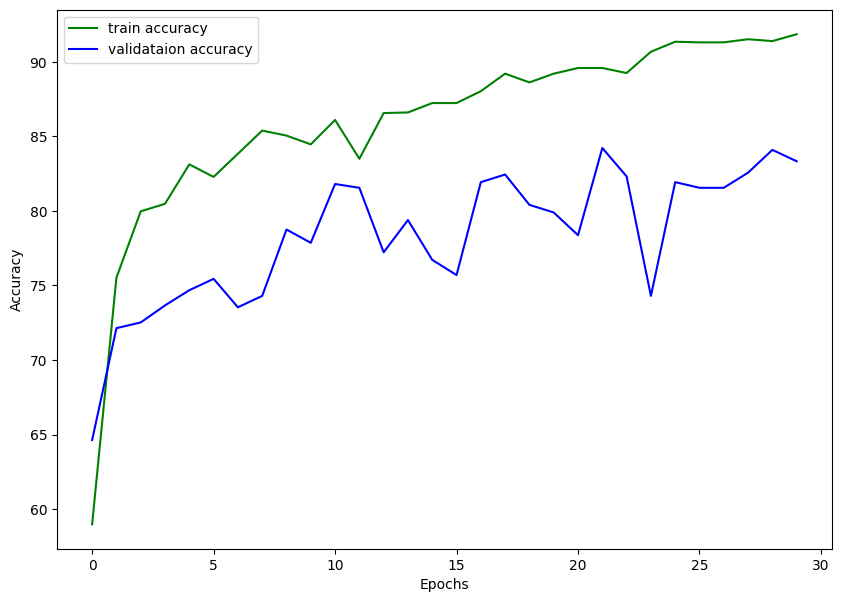

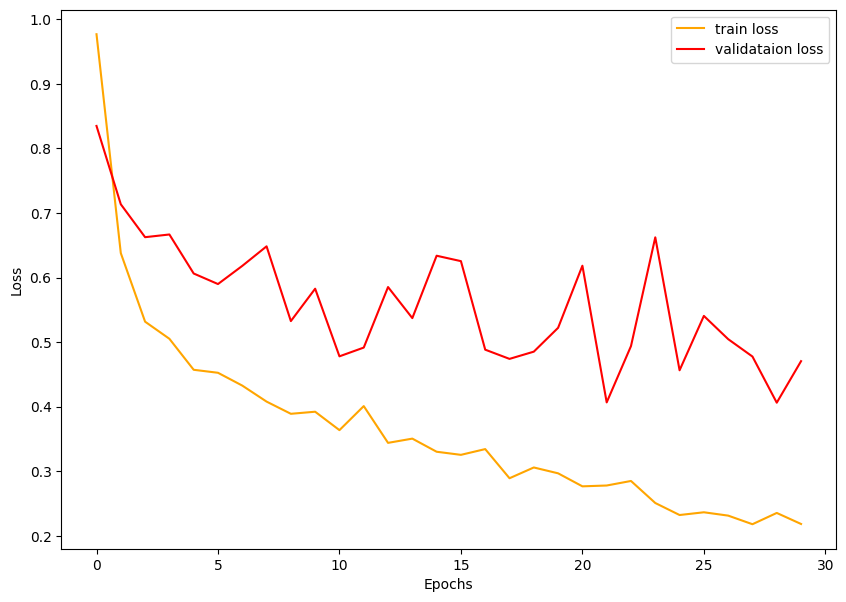

In [10]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [12]:
save_model(EPOCHS, model=model, optimizer=optimizer, criterion=criterion)

In [ ]:
# Define class labels
labels = ['balloning', 'cirrhosis', 'inflammation', 'steatosis'] 

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleClassifier().to(device)
checkpoint = torch.load('model.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# Define the preprocessing steps
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

# Load and preprocess the input image
input_image = Image.open('/content/102_1_8_25_jpg.rf.f57e83793438714c681c9aaa7222fe10.jpg')
input_tensor = transform(input_image).to(device)  # Move input tensor to the same device as the model

# Expand the input tensor to form a batch
input_batch = input_tensor.unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted = torch.max(output, 1)

# Get the class label
predicted_class = labels[predicted.item()]

print(predicted_class)


In [ ]:
#TODO: Attempt implementation of prognosis estimation